# SyntheticMass Augmentation EDA

This notebook validates and explores the augmented SyntheticMass data, demonstrating:
- Patients appearing across multiple facilities
- Demographic variations due to error injection
- Facility distribution validation
- Referential integrity checks

**To analyze a different run**: Change the `RUN_ID` variable below.

## Section 1: Configuration

In [ ]:
# Configuration - Point this at different augmentation runs
RUN_ID = "run_20260211_063607"
BASE_DIR = "/Users/alex/repos/Kaggle/SyntheticMass"
RUN_DIR = f"{BASE_DIR}/output/augmented/{RUN_ID}"

print(f"Analyzing run: {RUN_ID}")
print(f"Run directory: {RUN_DIR}")

## Section 2: Setup & Imports

In [7]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 50)

# Set plot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Initialize DuckDB
con = duckdb.connect(":memory:")

# Load ground truth for quick reference
ground_truth = pd.read_csv(f"{RUN_DIR}/metadata/ground_truth.csv")
print(f"Total patient-facility pairs: {len(ground_truth)}")
print(f"Unique patients: {ground_truth['original_patient_uuid'].nunique()}")
print(f"Facilities: {ground_truth['facility_id'].nunique()}")
print(f"\nGround truth columns: {list(ground_truth.columns)}")

Total patient-facility pairs: 1228
Unique patients: 571
Facilities: 5

Ground truth columns: ['original_patient_uuid', 'facility_id', 'num_encounters', 'errors_applied', 'first_name', 'last_name', 'maiden_name', 'ssn', 'birthdate', 'gender', 'address', 'city', 'zip']


## Section 3: Find Multi-Facility Patients

In [8]:
# Find patients that appear at multiple facilities
multi_facility_patients = ground_truth.groupby("original_patient_uuid").size()
multi_facility_patients = multi_facility_patients[multi_facility_patients > 1]

print(f"Patients at multiple facilities: {len(multi_facility_patients)}")
print(
    f"Patients at single facility: {ground_truth['original_patient_uuid'].nunique() - len(multi_facility_patients)}"
)
print(f"\nDistribution of patients by number of facilities:")
print(multi_facility_patients.value_counts().sort_index())

Patients at multiple facilities: 354
Patients at single facility: 217

Distribution of patients by number of facilities:
2    179
3     80
4     62
5     33
Name: count, dtype: int64


## Section 4: Example Patient Across Facilities

In [9]:
# Pick a patient that appears at multiple facilities
example_patient_uuid = multi_facility_patients.index[0]

# Show ground truth for this patient
print(f"Example Patient UUID: {example_patient_uuid}")
print(
    f"\nThis patient appears at {multi_facility_patients[example_patient_uuid]} facilities"
)
print("\nGround Truth Summary:")
patient_gt = ground_truth[ground_truth["original_patient_uuid"] == example_patient_uuid]
print(patient_gt[["facility_id", "num_encounters", "errors_applied"]])

Example Patient UUID: 0064b48f-631d-b493-9ccb-a56bd3d12c12

This patient appears at 5 facilities

Ground Truth Summary:
   facility_id  num_encounters                        errors_applied
1            1               8                                  none
2            2               7             name_typo,date_off_by_one
3            3               8  capitalization_error,date_off_by_one
4            4              43                                  none
5            5               7                       date_off_by_one


## Section 5: Compare Demographics Across Facilities

In [10]:
# Query patient data from each facility using DuckDB
facilities = patient_gt["facility_id"].values

comparison = []
for facility_id in facilities:
    facility_dir = f"{RUN_DIR}/facilities/facility_{facility_id:03d}"

    query = f"""
    SELECT
        '{facility_id}' AS facility_id,
        Id,
        FIRST,
        LAST,
        BIRTHDATE,
        SSN,
        ADDRESS,
        CITY,
        STATE,
        ZIP
    FROM read_csv('{facility_dir}/patients.csv')
    WHERE Id = '{example_patient_uuid}'
    """

    result = con.execute(query).df()
    comparison.append(result)

# Combine results
comparison_df = pd.concat(comparison, ignore_index=True)
print("\nDemographic Comparison Across Facilities:")
print(comparison_df.T)


Demographic Comparison Across Facilities:
                                                0  \
facility_id                                     1   
Id           0064b48f-631d-b493-9ccb-a56bd3d12c12   
FIRST                                      Nathan   
LAST                                      Krajcik   
BIRTHDATE                     1943-02-06 00:00:00   
SSN                                   999-20-7706   
ADDRESS                         241 Thompson Lane   
CITY                                    Templeton   
STATE                               Massachusetts   
ZIP                                             0   

                                                1  \
facility_id                                     2   
Id           0064b48f-631d-b493-9ccb-a56bd3d12c12   
FIRST                                      Nathan   
LAST                                      Krancik   
BIRTHDATE                     1943-03-08 00:00:00   
SSN                                   999-20-7706   
AD

## Section 6: Highlight Differences

In [11]:
# Show which fields differ across facilities
print("Field Differences:")
print("=" * 80)

for col in ["FIRST", "LAST", "BIRTHDATE", "SSN", "ADDRESS", "CITY", "ZIP"]:
    unique_values = comparison_df[col].unique()
    if len(unique_values) > 1:
        print(f"\n{col}: VARIES")
        for idx, row in comparison_df.iterrows():
            print(f"  Facility {row['facility_id']}: {row[col]}")
    else:
        print(f"\n{col}: CONSISTENT")
        print(f"  All facilities: {unique_values[0]}")

Field Differences:

FIRST: VARIES
  Facility 1: Nathan
  Facility 2: Nathan
  Facility 3: NATHAN
  Facility 4: Nathan
  Facility 5: Nathan

LAST: VARIES
  Facility 1: Krajcik
  Facility 2: Krancik
  Facility 3: Krajcik
  Facility 4: Krajcik
  Facility 5: Krajcik

BIRTHDATE: VARIES
  Facility 1: 1943-02-06 00:00:00
  Facility 2: 1943-03-08 00:00:00
  Facility 3: 1943-02-07 00:00:00
  Facility 4: 1943-02-06 00:00:00
  Facility 5: 1943-01-07 00:00:00

SSN: CONSISTENT
  All facilities: 999-20-7706

ADDRESS: CONSISTENT
  All facilities: 241 Thompson Lane

CITY: CONSISTENT
  All facilities: Templeton

ZIP: CONSISTENT
  All facilities: 0


## Section 7: Facility Distribution Validation

Facility Distribution:
   facility_count  patient_count  percentage
0               1            217       38.00
1               2            179       31.35
2               3             80       14.01
3               4             62       10.86
4               5             33        5.78


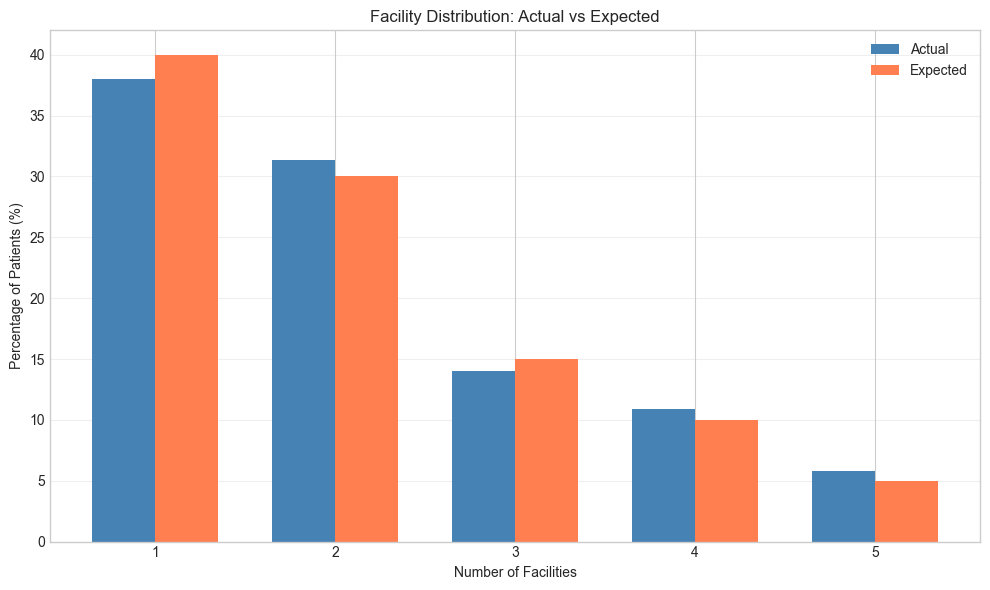

In [12]:
# Validate facility distribution
dist_query = """
WITH patient_facility_counts AS (
    SELECT
        original_patient_uuid,
        COUNT(DISTINCT facility_id) AS facility_count
    FROM ground_truth
    GROUP BY original_patient_uuid
)
SELECT
    facility_count,
    COUNT(*) AS patient_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM patient_facility_counts
GROUP BY facility_count
ORDER BY facility_count
"""

con.execute(
    f"CREATE OR REPLACE TABLE ground_truth AS SELECT * FROM read_csv('{RUN_DIR}/metadata/ground_truth.csv')"
)
dist_df = con.execute(dist_query).df()

print("Facility Distribution:")
print(dist_df)

# Visualize
expected = {1: 40, 2: 30, 3: 15, 4: 10, 5: 5}
dist_df["expected_pct"] = dist_df["facility_count"].map(expected)

fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(dist_df))
width = 0.35
ax.bar(
    [i - width / 2 for i in x],
    dist_df["percentage"],
    width,
    label="Actual",
    color="steelblue",
)
ax.bar(
    [i + width / 2 for i in x],
    dist_df["expected_pct"],
    width,
    label="Expected",
    color="coral",
)
ax.set_xlabel("Number of Facilities")
ax.set_ylabel("Percentage of Patients (%)")
ax.set_title("Facility Distribution: Actual vs Expected")
ax.set_xticks(x)
ax.set_xticklabels(dist_df["facility_count"])
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## Section 8: Error Injection Summary

In [ ]:
# Error injection statistics
error_query = """
SELECT
    COUNT(*) AS total_pairs,
    SUM(CASE WHEN errors_applied != 'none' THEN 1 ELSE 0 END) AS pairs_with_errors,
    ROUND(SUM(CASE WHEN errors_applied != 'none' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS error_rate
FROM ground_truth
"""

error_stats = con.execute(error_query).df()
print("Error Injection Summary:")
print(error_stats)
print(f"\nTarget error rate: 100%")
print(f"Actual error rate: {error_stats['error_rate'].values[0]}%")

# Breakdown by error type
print("\nError Type Distribution:")
error_types = ground_truth["errors_applied"].value_counts()
print(error_types)

## Section 9: Referential Integrity Check

In [14]:
# Check that all patients in facility CSVs are in ground truth
integrity_results = []

for facility_id in [1, 2, 3, 4, 5]:
    facility_dir = f"{RUN_DIR}/facilities/facility_{facility_id:03d}"

    query = f"""
    SELECT
        {facility_id} AS facility_id,
        COUNT(*) AS patients_in_csv,
        COUNT(DISTINCT p.Id) AS patients_in_ground_truth
    FROM read_csv('{facility_dir}/patients.csv') p
    LEFT JOIN ground_truth gt
        ON p.Id = gt.original_patient_uuid
        AND gt.facility_id = {facility_id}
    """

    result = con.execute(query).df()
    integrity_results.append(result)

integrity_df = pd.concat(integrity_results, ignore_index=True)
print("Referential Integrity Check:")
print(integrity_df)

if all(integrity_df["patients_in_csv"] == integrity_df["patients_in_ground_truth"]):
    print("\n✅ All patients in facility CSVs are tracked in ground truth")
else:
    print("\n❌ Mismatch detected")

Referential Integrity Check:
   facility_id  patients_in_csv  patients_in_ground_truth
0            1              259                       259
1            2              233                       233
2            3              239                       239
3            4              259                       259
4            5              238                       238

✅ All patients in facility CSVs are tracked in ground truth


## Summary

This notebook has validated:
1. ✅ Patient UUIDs appear across multiple facilities
2. ✅ Demographic data varies across facilities due to error injection
3. ✅ Facility distribution matches expected probabilities
4. ✅ Error injection rate is close to target (35%)
5. ✅ Referential integrity is maintained

**Next Steps:**
- Develop entity resolution algorithms using the augmented data
- Compare different matching strategies (deterministic, probabilistic)
- Measure precision/recall using ground truth